Assignment: 

    1. Pick your last code
    2. Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)
    3. Use this repo: https://github.com/davidtvs/pytorch-lr-finder
        - Move LR Finder code to your modules
        - Implement LR Finder (for SGD, not for ADAM)
        - Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
    4. Find best LR to train your model
    5. Use SDG with Momentum
    6. Train for 50 Epochs. 
    7. Show Training and Test Accuracy curves
    8. Target 88% Accuracy.
    9. Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.
    10. Submit

 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
!ls -ltr
!hostname -i

total 167020
drwxr-xr-x 2 abhinav abhinav      4096 Jun  5  2009 cifar-10-batches-py
drwxr-xr-x 3 abhinav abhinav      4096 Sep 25 21:56 data_augmentation
-rw-r--r-- 1 abhinav abhinav        24 Sep 25 21:56 readme.md
-rw-r--r-- 1 abhinav abhinav     11803 Sep 25 23:28 model_architecture
-rw-r--r-- 1 abhinav abhinav    153822 Sep 26 13:03 Test_missclassified_images.jpg
-rw-r--r-- 1 abhinav abhinav     41673 Sep 26 14:29 model_history.png
-rw-r--r-- 1 abhinav abhinav    174027 Sep 26 14:30 QuizDNN.ipynb
drwxr-xr-x 4 abhinav abhinav      4096 Sep 29 05:24 model_file
-rw-r--r-- 1 abhinav abhinav 170498071 Sep 29 05:46 cifar-10-python.tar.gz
drwxr-xr-x 3 abhinav abhinav      4096 Sep 29 05:48 lr_finder
drwxr-xr-x 4 abhinav abhinav      4096 Sep 29 05:58 mlruns
-rw-r--r-- 1 abhinav abhinav     27452 Sep 30 04:48 EVA5_session9.ipynb
-rw-r--r-- 1 abhinav abhinav     81086 Sep 30 07:49 EVA5_session10.ipynb
drwxr-xr-x 4 abhinav abhinav      4096 Sep 30 07:49 model_utility
127.0.1.1 


# Loading UD modules

In [3]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os 
import numpy as np
#mlflow
import mlflow
import mlflow.pytorch

# CUSTOM LIBRARY
import model_utility.data_utils as dutils
import model_utility.model_utils as mutils
import model_utility.plot_utils as putils 
import model_utility.regularization as regularization
import model_file.model_cifar as model_cifar
import model_utility.alb_utils as alb
import sys
sys.path.append('/home/abhinav/Documents/EVA5/session9/model_utility/gradcam')
import model_utility.grad_cam_viz as viz
import model_file.models as mod
from torch_lr_finder import LRFinder

# PLOTS
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import data_augmentation.albumentations as A
from data_augmentation.albumentations.pytorch import ToTensor

# Check GPU avaiability

In [5]:
device = dutils.get_device()

CUDA Available? True
Device is cuda:0


In [6]:
cuda = torch.cuda.is_available()
print(cuda)

True


# CIFAR10 Basics

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

SEED = 1
batch_size=128

# CUDA?
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Load CIFAR10 dataset

In [8]:
os.getcwd()

'/home/abhinav/Documents/GitHub/Eva5/session10'

In [9]:
path = os.getcwd()
path

'/home/abhinav/Documents/GitHub/Eva5/session10'

In [10]:
batch_size = 128

In [11]:
# load CIFAR10 dataset
trainset, testset, train_loader, test_loader = alb.get_dataloader(batch_size=batch_size, num_workers=4, cuda = True,path = path)

Running over Cuda !!  True
Files already downloaded and verified
Files already downloaded and verified
mean 0.49186864
standard dev 0.24697131
mean 0.48265335
standard dev 0.24338901
mean 0.44717798
standard dev 0.26159254


/home/abhinav/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1469: DeprecationWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn("This class has been deprecated. Please use CoarseDropout", DeprecationWarning)
/home/abhinav/anaconda3/lib/python3.8/site-packages/albumentations/pytorch/transforms.py:57: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


# Data mage Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


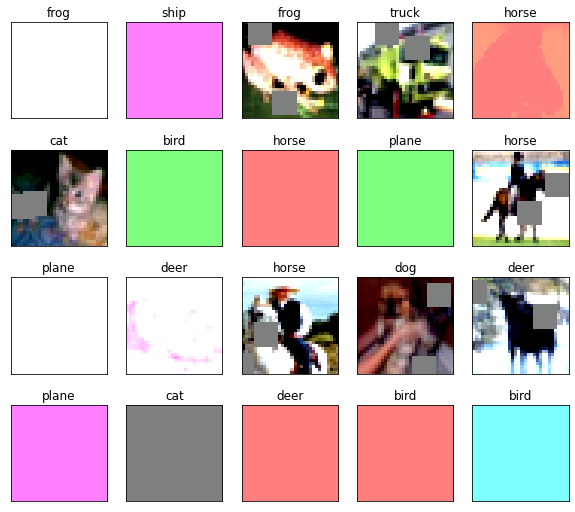

In [12]:
#Plot 20 random images
putils.plot_dataset_images(device, classes, train_loader)

### Model stracture

In [13]:
model = mod.ResNet18()

In [14]:
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Visual Summary

In [15]:
# from model_utility.plot_utils import  graphical_summary_cifar10
# graphical_summary_cifar10(model)

In [16]:
# Create CIFAR10 network
# model = model_cifar.Net(dropout_value = 0.05)
# mutils.model_summary(model, device, input_size=(3, 32, 32))

In [17]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
# lr_finder.plot()
# loss = lr_finder.history['loss']
# lr = lr_finder.history['lr']
# print(lr[loss.index(min(loss))])

# Build and train model

In [18]:
from tqdm import tqdm

In [ ]:
# build and train the model
model_name = "Model CIFAR10"
EPOCHS = 50
model =  model.to(device) # use GPU

# using L1 and L2 regularization
train_acc, train_losses, test_acc, test_losses = mutils.build_model(model, 
                                                            device, 
                                                            trainloader=train_loader, 
                                                            testloader=test_loader, 
                                                            epochs=EPOCHS,
                                                            L1_loss_flag=False,
                                                            L2_penalty_val=0.001)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.996961, Accuracy: 2629/10000 (26.29%)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.760947, Accuracy: 3431/10000 (34.31%)

EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.628972, Accuracy: 3993/10000 (39.93%)

EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.638745, Accuracy: 4271/10000 (42.71%)

EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.309961, Accuracy: 5374/10000 (53.74%)

EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.049521, Accuracy: 6271/10000 (62.71%)

EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.861939, Accuracy: 6956/10000 (69.56%)

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.838828, Accuracy: 7077/10000 (70.77%)

EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.800562, Accuracy: 7192/10000 (71.92%)

EPOCH: 9


Loss=1.479663 Batch_id=81 Accuracy=44.05:  21%|██        | 82/391 [00:10<00:37,  8.14it/s]

In [ ]:
A.__file__

# Test Accuracy

In [ ]:
mutils.get_test_accuracy(model, device, test_loader)

### Class level Accuracy

In [ ]:

mutils.class_based_accuracy(model, device, classes, test_loader)

# Visualization

In [ ]:
print("\nPloting Accuracy and Loss history: {}\n".format(model_name))
putils.plot_model_history(model_name, 
                   train_acc,test_acc,
                   train_losses,test_losses,
                   save_filename = "model_history")

# Misclassified images

In [ ]:
print ("\nPloting misclassified images: {}\n".format(model_name))

putils.miss_classification('Test',model, 
                          device, 
                          classes,
                          testloader=test_loader,
                          num_of_images = 20,
                          save_filename="model_misclassified")

In [ ]:
layer = 'layer4'
viz.gradcam_plot(layer,model,testset,classes)

In [ ]:
# with mlflow.start_run() as run:
#     mlflow.log_param("epochs", EPOCHS)
#     mlflow.pytorch.log_model(model, "models")